In [99]:
# Import our dependencies
import pandas as pd
import tensorflow as tf
import seaborn as sb
import numpy as np
import warnings
import datetime as dt
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [100]:
# Get file path of our csv
file_path = 'data/english_video_data.csv'

In [101]:
# Read in the csv to a Pandas DataFrame
videos_df = pd.read_csv(file_path)
videos_df.head()

,c_channel_id,v_video_id,v_date_publishedAt,v_time_publishedAt,c_channel_title,c_channel_upload_playlist,c_channel_subCount,c_channel_videoCount,c_channel_viewCount,v_category_id,...,v_comment_count,v_likes,v_favorites,v_views,v_definition,v_duration,v_caption,v_age_restricted,v_privacy_status,v_made_for_kids
0,UC295-Dw_tDNtZXFeAPAW6Aw,oGga7hZypCs,2024-09-02,11:00:48,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,28,442,0,76602,hd,2:03:35,False,Not Restricted,public,False
1,UC295-Dw_tDNtZXFeAPAW6Aw,pkzIiXkRxB0,2024-08-30,11:00:54,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,21,1165,0,341133,hd,2:01:48,False,Not Restricted,public,False
2,UC295-Dw_tDNtZXFeAPAW6Aw,TUS8vZaHNds,2024-08-31,11:00:26,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,43,1374,0,222425,hd,1:00:04,False,Not Restricted,public,False
3,UC295-Dw_tDNtZXFeAPAW6Aw,rBzKTkUG3Wk,2024-08-31,13:00:57,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,19,274,0,40821,hd,1:01:09,False,Not Restricted,public,False
4,UC295-Dw_tDNtZXFeAPAW6Aw,XHQP6mut8YI,2024-09-01,11:00:36,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,27,485,0,82374,hd,0:20:16,False,Not Restricted,public,False


In [102]:
# Determine the number of unique values in each column.
videos_df.nunique()

c_channel_id                   400
v_video_id                   22516
v_date_publishedAt             366
v_time_publishedAt           12795
c_channel_title                400
c_channel_upload_playlist      400
c_channel_subCount             350
c_channel_videoCount           318
c_channel_viewCount            400
v_category_id                   15
v_tags                        8717
v_title                      21557
v_description                13500
v_comment_count                593
v_likes                       3268
v_favorites                      1
v_views                      13374
v_definition                     2
v_duration                    3020
v_caption                        2
v_age_restricted                 2
v_privacy_status                 1
v_made_for_kids                  2
dtype: int64

In [103]:
# Drop v_favorites and v_privacy_status since they only have one value
videos_df_2 = videos_df.drop(['v_favorites', 'v_privacy_status','c_channel_id', 'v_video_id', 'c_channel_upload_playlist'], axis=1)

In [104]:
# converting date and time published to datetime type
videos_df_2['v_date_publishedAt'] = videos_df_2['v_date_publishedAt'].astype('datetime64[s]')
videos_df_2['v_time_publishedAt'] = videos_df_2['v_time_publishedAt'].astype('datetime64[s]')

In [105]:
# splitting the date and time published into separate columns
videos_df_2['v_year'] = videos_df_2['v_date_publishedAt'].dt.year
videos_df_2['v_mont'] = videos_df_2['v_date_publishedAt'].dt.month
videos_df_2['v_day'] = videos_df_2['v_date_publishedAt'].dt.day
videos_df_2['v_hour'] = videos_df_2['v_time_publishedAt'].dt.hour
videos_df_2['v_minute'] = videos_df_2['v_time_publishedAt'].dt.minute
videos_df_2['v_second'] = videos_df_2['v_time_publishedAt'].dt.second

In [106]:
# Drop 2 columns no longer needed
videos_df_2.drop(['v_date_publishedAt', 'v_time_publishedAt'], axis=1, inplace=True)

In [107]:
# Transforming durationg to a datetime object
videos_df_2['v_duration_time'] = pd.to_timedelta(videos_df_2['v_duration'])

In [108]:
# converting the duration into total seconds
videos_df_2['v_duration_time'] = videos_df_2['v_duration_time'].dt.total_seconds()

# drop the old duration column
videos_df_2.drop(['v_duration'], axis=1, inplace=True)

In [109]:
# Copy the data frame
videos_df_cats = videos_df_2.copy()

In [110]:
# Check how many different categgory id's we have
videos_df_cats['v_category_id'].value_counts()

v_category_id
26    14635
22     2299
24     1502
2      1370
27      996
28      931
1       290
20      213
19       78
29       64
17       61
25       58
15       11
10        5
23        3
Name: count, dtype: int64

In [111]:
# Creat a dictionary of all the diferent category id's
categories = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

In [112]:
# A function that can be used to replace a dategory id with its category name
def name_categories(df, category_dict):
    for index, row in df.iterrows():
        if row['v_category_id'] in [23, 10, 17, 15, 19]:
            df.at[index, 'v_category_id'] = "other"
        elif row['v_category_id'] in category_dict:
            df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]

    return df


In [113]:
# Use function name_categories to change data to the actual 'v_category_id' name
videos_df_cats = name_categories(videos_df_cats, categories)

## Messing with tags

In [114]:
# R² Score: 0.6714833327132073 (with column cut 3 and no buckets for channel viewcount)
# A function used to expand tags into multiple unique columns, then gives a 0 or 1 based on if that row had that tag
def expand_tags(df, column_name):
    all_tags = set(tag for tags in df[column_name] for tag in tags)
    for tag in all_tags:
        col_name = f'v_tag_{tag}'
        df[col_name] = df[column_name].apply(lambda tags: 1 if tag in tags else 0)
    
    return df

# Use the function expand_tags to break each tag into its own column
video_df_tags = expand_tags(videos_df_cats,'v_tags')

In [115]:
# # R² Score: 0.6638668962231091 (with column cut 3 and no buckets for channel viewcount)
# from collections import Counter
# import re

# # Combine all text into a single string
# all_tags = ','.join(videos_df_cats['v_tags'])

# # Split the text into words and convert to lowercase
# tags = all_tags.lower().split(',')

# # Count the frequency of each word
# tags_counts = Counter(tags)

# # Get the most common words
# top_tags = tags_counts.most_common(1000)  # Get top 1000 words

# # Process the list to extract the words only
# popular_tags = [re.sub(r"[^a-zA-Z0-9\s]", "", item[0]).strip() for item in top_tags if re.sub(r"[^a-zA-Z0-9\s]", "", item[0]).strip()]

# def split_tags_into_columns(df, tags_list):
#     df['v_tags'] = df['v_tags'].apply(lambda x: x if isinstance(x, list) else [])
#     for tag in tags_list:
#         column_name = f'v_tag_{tag}'
#         df[column_name] = df['v_tags'].apply(lambda tags: 1 if tag in tags else 0)

#     return df

# video_df_tags = split_tags_into_columns(videos_df_cats, popular_tags)

In [116]:
# # R² Score: 0.6645239430214959 (with column cut 3 and no buckets for channel viewcount)
# from collections import Counter
# import re

# # Combine all text into a single string
# all_tags = ','.join(videos_df_cats['v_tags'])

# # Split the text into words and convert to lowercase
# tags = all_tags.lower().split(',')

# # Count the frequency of each word
# tags_counts = Counter(tags)

# # Get the most common words
# top_tags = tags_counts.most_common(100)  # Get top 100 words

# # Process the list to extract the words only
# popular_tags = [re.sub(r"[^a-zA-Z0-9\s]", "", item[0]).strip() for item in top_tags if re.sub(r"[^a-zA-Z0-9\s]", "", item[0]).strip()]

# def split_tags_into_columns(df, tags_list):
#     df['v_tags'] = df['v_tags'].apply(lambda x: x if isinstance(x, list) else [])
#     for tag in tags_list:
#         column_name = f'v_tag_{tag}'
#         df[column_name] = df['v_tags'].apply(lambda tags: 1 if tag in tags else 0)

#     return df

# video_df_tags = split_tags_into_columns(videos_df_cats, popular_tags)

## Messing with different bucketing

In [117]:
# # R² Score: 0.6617587513624208 (with column cut 3)

# # Used to bucket channel viewcount
# def bucketize_channel_viewcount(df, column, bins=10):
#     df = df.copy()

#     bin_ranges, bin_labels = pd.qcut(df[column], q=bins, retbins=True, duplicates='drop')

#     labels = [f"Bucket {i+1} ({int(bin_labels[i])}-{int(bin_labels[i+1])})" for i in range(len(bin_labels)-1)]

#     df[f"{column}_bucket"] = pd.qcut(df[column], q=bins, labels=labels, duplicates='drop')

#     return df

# video_df_tags = bucketize_channel_viewcount(video_df_tags, 'c_channel_viewCount', bins=10)
# video_df_tags.drop(columns=['c_channel_viewCount'], axis=1, inplace =True)
# video_df_tags['c_channel_viewCount_bucket'].value_counts()

In [118]:
# # R² Score: 0.6582374302189562 (with column cut 3)

# # A function used to bucked video viewcount for each video into the appropriate bucket
# def bucketize_channel_viewcount(df, column_name):
#     bins = [-1, 1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000, 28_000_000_000]
#     labels = [
#         "Very Low (0 - 1K)",
#         "Low (1K - 10K)",
#         "Moderate (10K - 100K)",
#         "Growing (100K - 1M)",
#         "Established (1M - 10M)",
#         "Popular (10M - 100M)",
#         "Trending (100M - 1B)",
#         "Viral (1B - 10B)",
#         "Mega Viral (10B+)"
#     ]
#     df["c_channel_viewCount_bucket"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True)
    
#     return df

# # Use the function bucket_views to bucket each video viewcount
# bucket_video_df = bucketize_channel_viewcount(video_df_tags, 'c_channel_viewCount')
# bucket_video_df.drop(columns=['c_channel_viewCount'], axis=1, inplace =True)
# bucket_video_df['c_channel_viewCount_bucket'].value_counts()

In [119]:
# # going to bucket subscriber coutn and channel video count

## Bucketing video viewcount for Random Forest output

In [120]:
# A function used to bucked video viewcount for each video into the appropriate bucket
def bucket_views(df, column_name):
    # Some Buckets
    # bins = [-1, 1000, 10000, 100000, 1000000, float("inf")]
    # labels = ["Very Low (0-1,000)", "Low (1,000-10,000)", "Medium (10,000-100,000)", "High (100,000-1,000,000)", "Very High (1,000,000+)"]
    # More Buckets
    bins = [-1, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, float("inf")]
    labels = [
        "Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"
    ]
    # Most Buckets
    # bins = [-1, 500, 1000, 5000, 10000, 25000, 50000, 100000, 250000, 500000, 1000000, 5000000, float("inf")]
    # labels = [
    #     "Very Low (0 - 500)",
    #     "Low (500 - 1K)",
    #     "Moderate (1K - 5K)",
    #     "Growing (5K - 10K)",
    #     "Established (10K - 25K)",
    #     "Popular (25K - 50K)",
    #     "Trending (50K - 100K)",
    #     "Well Known (100K - 250K)",
    #     "Famous (250K - 500K)",
    #     "Viral (500K - 1M)",
    #     "Superstar (1M - 5M)",
    #     "Mega Viral (5M+)"
    # ]
    df["view_bucket"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True)
    
    return df

# Use the function bucket_views to bucket each video viewcount
bucket_video_df = bucket_views(video_df_tags, 'v_views')
bucket_video_df.drop(columns=['v_views'], axis=1, inplace =True)
bucket_video_df['view_bucket'].value_counts()

view_bucket
Low (1K - 5K)               6825
Very Low (0 - 1K)           5072
Growing (10K - 50K)         4546
Moderate (5K - 10K)         3334
Popular (100K - 500K)       1235
Established (50K - 100K)    1039
Viral (1M+)                  251
Trending (500K - 1M)         214
Name: count, dtype: int64

## Trying cutting out different columns

In [121]:
# randomize the order of the dataframe
bucket_video_df = bucket_video_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [122]:
# # Column cut 1
# # R² Score: ~0.669044272100044 (with no bucketing except for output)

# # Use get dummies to make sure our data can be used in the ML model
# videos_df_dummies = pd.get_dummies(data= bucket_video_df, columns=['v_category_id','v_definition','v_caption','v_age_restricted','v_made_for_kids'],dtype=int)

# # use label encoder to change out buckets from strings to diggits so the ML model can use it
# encoder = LabelEncoder()
# videos_df_dummies["view_bucket_encoded"] = encoder.fit_transform(videos_df_dummies["view_bucket"])

# # Drop some un needed columns that have text or are just not needed
# videos_df_dummies.drop(columns=['v_tags','v_title','v_description','c_channel_title','view_bucket'], axis=1, inplace =True)

In [123]:
# # Column cut 2
# # R² Score: ~0.6682990051378332 (with no bucketing except for output)

# # Use get dummies to make sure our data can be used in the ML model
# videos_df_dummies = pd.get_dummies(data= bucket_video_df, columns=['v_category_id'],dtype=int)

# # use label encoder to change out buckets from strings to diggits so the ML model can use it
# encoder = LabelEncoder()
# videos_df_dummies["video_views_bucket_encoded"] = encoder.fit_transform(videos_df_dummies["view_bucket"])

# # Drop some un needed columns that have text or are just not needed
# videos_df_dummies.drop(columns=['v_tags','v_title','v_description','c_channel_title','view_bucket','v_definition','v_caption','v_age_restricted','v_made_for_kids'], axis=1, inplace =True)

In [124]:
# Column cut 3
# R² Score: 0.6714833327132073 (with no bucketing except for output but some buckets)
# R² Score: 0.6792498433603842 (with no bucketing except for output but more buckets)
# R² Score: 0.5187405197962076 (with no bucketing except for output but most buckets)

# Use get dummies to make sure our data can be used in the ML model
videos_df_dummies = pd.get_dummies(data= bucket_video_df, columns=['v_category_id'],dtype=int)

# use label encoder to change out buckets from strings to diggits so the ML model can use it
encoder = LabelEncoder()
videos_df_dummies["video_views_bucket_encoded"] = encoder.fit_transform(videos_df_dummies["view_bucket"])
#videos_df_dummies["channel_views_bucket_encoded"] = encoder.fit_transform(videos_df_dummies["c_channel_viewCount_bucket"])

# Drop some un needed columns that have text or are just not needed
# videos_df_dummies.drop(columns=[
#     'v_tags','v_title','v_description','c_channel_title','view_bucket','v_definition','v_caption','v_age_restricted','v_made_for_kids',
#     'v_year','v_mont','v_day','v_hour','v_minute','v_second','c_channel_viewCount_bucket'
#     ], axis=1, inplace =True)

videos_df_dummies.drop(columns=[
    'v_tags','v_title','v_description','c_channel_title','view_bucket','v_definition','v_caption','v_age_restricted','v_made_for_kids',
    'v_year','v_mont','v_day','v_hour','v_minute','v_second'
    ], axis=1, inplace =True)

In [125]:
# # Column cut 4
# # R² Score: ~0.671027915566464 (with no bucketing except for output)

# # Use get dummies to make sure our data can be used in the ML model
# videos_df_dummies = pd.get_dummies(data= bucket_video_df, columns=['v_category_id','v_definition','v_caption','v_age_restricted','v_made_for_kids'],dtype=int)

# # use label encoder to change out buckets from strings to diggits so the ML model can use it
# encoder = LabelEncoder()
# videos_df_dummies["video_views_bucket_encoded"] = encoder.fit_transform(videos_df_dummies["view_bucket"])

# # Drop some un needed columns that have text or are just not needed
# videos_df_dummies.drop(columns=[
#     'v_tags','v_title','v_description','c_channel_title','view_bucket','v_views',
#     'v_year','v_mont','v_day','v_hour','v_minute','v_second'
#     ], axis=1, inplace =True)

## Building the Random Forest Model

In [128]:
# Split our preprocessed data into our features and target arrays
y = videos_df_dummies['video_views_bucket_encoded'].values
X = videos_df_dummies.drop(columns=['video_views_bucket_encoded']).values

In [67]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) #train_test_split(X, y,random_state=42)

In [68]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [69]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [33]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Create the random forest classifier instance
#rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model = RandomForestRegressor(n_estimators=500, random_state=42) #RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

In [35]:
# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [36]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

In [37]:
# Calculate and Print our R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.6699960243678691


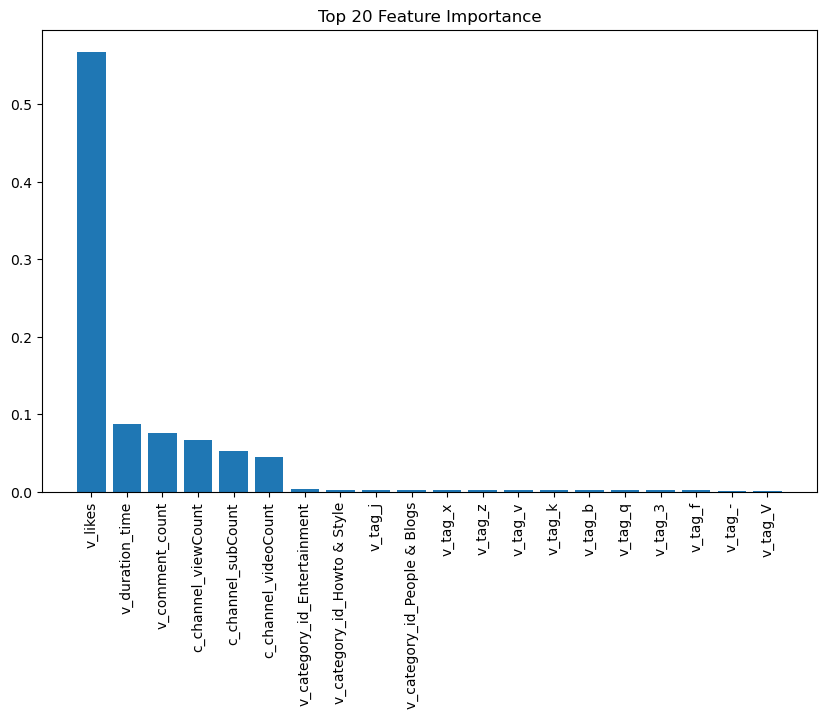

In [38]:
importances = rf_model.feature_importances_

feature_names = videos_df_dummies.drop(columns=['video_views_bucket_encoded']).columns

indices = np.argsort(importances)[::-1]

top_10_indices = indices[:20]
#bottom_10_indices = indices[-10:]

#combined_indices = np.concatenate([top_10_indices, bottom_10_indices])
combined_indices = top_10_indices

combined_feature_names = [feature_names[i] for i in combined_indices]
combined_importances = importances[combined_indices]

plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importance")
plt.bar(range(len(combined_importances)), combined_importances, align="center")
plt.xticks(range(len(combined_importances)), combined_feature_names, rotation=90)
plt.show()